In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import os

In [44]:
df = pd.read_csv('C:/Users/Microsoft/Desktop/Projects/Python Projects/Manutencao-Preditiva/data/ai4i2020.csv')
df = df.drop(columns=['Product ID'], errors='ignore')

In [45]:
# Encoding do Type
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

# Features 
features = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
            'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

X = df[features]
y = df['Machine failure']


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
# Lista de modelos com hiperparâmetros básicos otimizados para esse dataset
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=300, max_depth=12, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8,
        random_state=42
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=300, max_depth=12, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
}

In [49]:
# Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar resultados
results = {}


In [50]:
for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Cross-validation para AUC e Recall
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(recall_score))
    
    # Treina no treino completo para avaliação final
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    auc_test = roc_auc_score(y_test, y_prob)
    recall_test = recall_score(y_test, y_pred)
    
    results[name] = {
        'AUC CV Mean': auc_scores.mean(),
        'AUC CV Std': auc_scores.std(),
        'Recall CV Mean': recall_scores.mean(),
        'AUC Test': auc_test,
        'Recall Test': recall_test,
        'model': model
    }
    
    print(f"{name} - AUC CV: {auc_scores.mean():.4f} (±{auc_scores.std():.4f}) | Recall CV: {recall_scores.mean():.4f}")


Treinando Logistic Regression...
Logistic Regression - AUC CV: 0.8956 (±0.0162) | Recall CV: 0.8156

Treinando Random Forest...
Random Forest - AUC CV: 0.9711 (±0.0131) | Recall CV: 0.6128

Treinando Gradient Boosting...
Gradient Boosting - AUC CV: 0.9728 (±0.0120) | Recall CV: 0.6681

Treinando Extra Trees...
Extra Trees - AUC CV: 0.9558 (±0.0082) | Recall CV: 0.7601


In [51]:
# Tabela comparativa
results_df = pd.DataFrame(results).T.drop('model', axis=1)
results_df = results_df.sort_values(by=['AUC Test', 'Recall Test'], ascending=False)
print("\nTabela Comparativa:")
print(results_df.round(4))



Tabela Comparativa:
                    AUC CV Mean AUC CV Std Recall CV Mean  AUC Test  \
Gradient Boosting      0.972751    0.01196       0.668081  0.969762   
Random Forest          0.971137   0.013115       0.612795  0.961055   
Extra Trees            0.955817    0.00819       0.760135  0.959254   
Logistic Regression    0.895621   0.016229       0.815623  0.906497   

                    Recall Test  
Gradient Boosting      0.705882  
Random Forest          0.720588  
Extra Trees            0.794118  
Logistic Regression    0.823529  


<Figure size 1200x600 with 0 Axes>

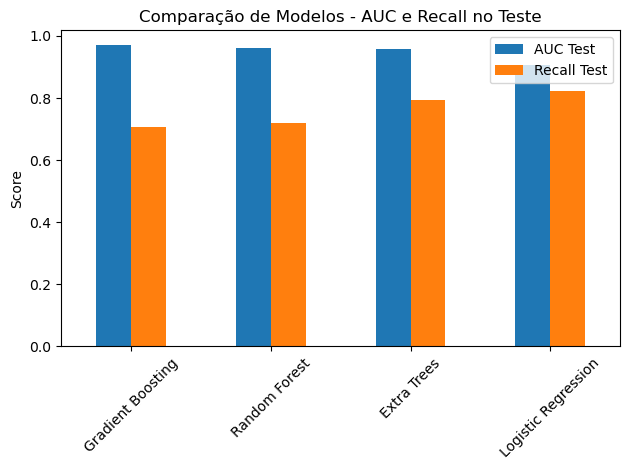

In [52]:
# Gráfico de barras
plt.figure(figsize=(12, 6))
results_df[['AUC Test', 'Recall Test']].plot(kind='bar')
plt.title('Comparação de Modelos - AUC e Recall no Teste')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Escolhe o melhor 
best_model_name = results_df.index[0]
best_model = results[best_model_name]['model']
print(f"\nMelhor modelo: {best_model_name}")
print(f"AUC Test: {results[best_model_name]['AUC Test']:.4f} | Recall Test: {results[best_model_name]['Recall Test']:.4f}")


Melhor modelo: Gradient Boosting
AUC Test: 0.9698 | Recall Test: 0.7059


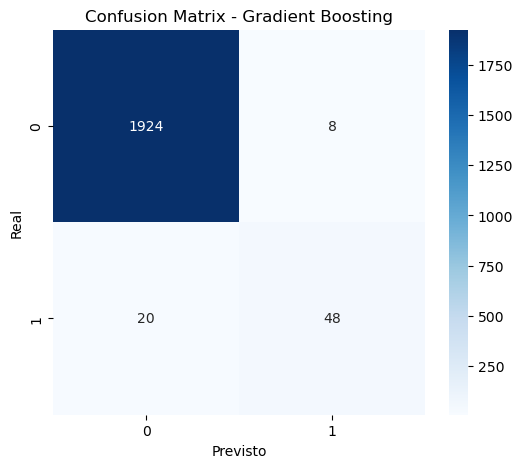

In [54]:
# Confusion Matrix do melhor
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

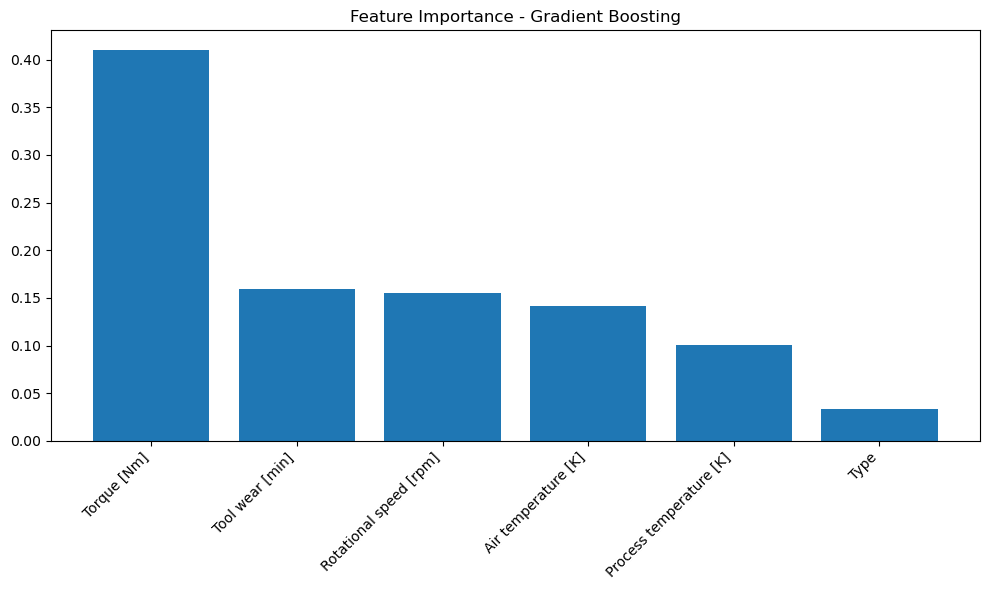

In [55]:
# Feature Importance (se o modelo tiver)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45, ha='right')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

In [57]:
joblib.dump(best_model, 'model/best_model.pkl')
print(f"\nModelo salvo: model/best_model.pkl ({best_model_name})")


Modelo salvo: model/best_model.pkl (Gradient Boosting)
